# PLN Project 3 - LLM Prompt Engineering for Text Classification

In [1]:
# Package Importation

import os
import re
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from huggingface_hub import hf_hub_download
from llama_cpp import Llama
from tqdm import tqdm

In [2]:
# Data Loading & Splitting

print("--- Loading Dataset ---")
url = "https://raw.githubusercontent.com/franciellevargas/HateBR/refs/heads/main/dataset/HateBR.csv"
df = pd.read_csv(url)

# Map labels for clarity
df['label_text'] = df['label_final'].map({0: 'Não ofensivo', 1: 'Ofensivo'})

X = df['comentario']
y = df['label_final']

# 80% Train, 20% Test split, random_state=42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

train_df = pd.DataFrame({'text': X_train, 'label': y_train, 'label_text': y_train.map({0: 'Não ofensivo', 1: 'Ofensivo'})})
test_df = pd.DataFrame({'text': X_test, 'label': y_test, 'label_text': y_test.map({0: 'Não ofensivo', 1: 'Ofensivo'})})

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

--- Loading Dataset ---
Train size: 5600
Test size: 1400


In [3]:
# Load Model Qwen2.5 Intructions 7B
print("\nDownloading & Loading Qwen2.5 GPU Model")

model_folder = "models"

model_path = hf_hub_download(
    repo_id="bartowski/Qwen2.5-7B-Instruct-GGUF",
    filename="Qwen2.5-7B-Instruct-Q4_K_M.gguf",
    local_dir=model_folder,
    force_download=True
    )

qwen = Llama(
    model_path=model_path,
    n_gpu_layers=-1,
    n_ctx=2048,
    verbose=True
)

print("Qwen2.5 loaded successfully!")

Qwen2.5-7B-Instruct-Q4_K_M.gguf:   0%|          | 0.00/4.68G [00:00<?, ?B/s]

ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    yes
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9, VMM: yes
llama_load_model_from_file: using device CUDA0 (NVIDIA GeForce RTX 4060 Laptop GPU) - 7099 MiB free
llama_model_loader: loaded meta data with 38 key-value pairs and 339 tensors from models\Qwen2.5-7B-Instruct-Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Qwen2.5 7B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = Instruct
llama_model_loader: - kv   4:          

Qwen2.5 loaded successfully!


CUDA : ARCHS = 500,520,530,600,610,620,700,720,750,800,860,870,890,900 | FORCE_MMQ = 1 | USE_GRAPHS = 1 | PEER_MAX_BATCH_SIZE = 128 | CPU : SSE3 = 1 | SSSE3 = 1 | AVX = 1 | AVX2 = 1 | F16C = 1 | FMA = 1 | LLAMAFILE = 1 | OPENMP = 1 | AARCH64_REPACK = 1 | 
Model metadata: {'general.name': 'Qwen2.5 7B Instruct', 'general.architecture': 'qwen2', 'general.type': 'model', 'general.basename': 'Qwen2.5', 'general.finetune': 'Instruct', 'general.size_label': '7B', 'general.license': 'apache-2.0', 'qwen2.attention.head_count_kv': '4', 'general.license.link': 'https://huggingface.co/Qwen/Qwen2.5-7B-Instruct/blob/main/LICENSE', 'general.base_model.count': '1', 'general.base_model.0.name': 'Qwen2.5 7B', 'general.base_model.0.organization': 'Qwen', 'general.base_model.0.repo_url': 'https://huggingface.co/Qwen/Qwen2.5-7B', 'qwen2.block_count': '28', 'qwen2.context_length': '32768', 'quantize.imatrix.dataset': '/training_dir/calibration_datav3.txt', 'qwen2.embedding_length': '3584', 'general.quantiza

In [3]:
# Load Model Llama3.1 Instruct 8B
print("\nDownloading & Loading Llama 3.1 GPU Model")

model_path = hf_hub_download(
    repo_id="bartowski/Meta-Llama-3.1-8B-Instruct-GGUF",
    filename="Meta-Llama-3.1-8B-Instruct-Q4_K_M.gguf",
    local_dir="models",
)

# Llama initiallization with GPU offloading
llama = Llama(
    model_path=model_path,
    n_gpu_layers=-1,
    n_ctx=2048,
    verbose=True
)

print("Llama 3.1 loaded successfully!")

ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    yes
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9, VMM: yes
llama_load_model_from_file: using device CUDA0 (NVIDIA GeForce RTX 4060 Laptop GPU) - 7099 MiB free
llama_model_loader: loaded meta data with 33 key-value pairs and 292 tensors from models\Meta-Llama-3.1-8B-Instruct-Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Meta Llama 3.1 8B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = Instruct
llama_model_loader: - kv 

Llama 3.1 loaded successfully!


## Prompt Engineering Classification

In [4]:
def query_llm(prompt, llm):
    """
    Sends prompt using Qwen's ChatML format via llama.cpp
    """
    messages = [
        {"role": "system", "content": "You are a helpful assistant that classifies text in Portuguese."},
        {"role": "user", "content": prompt}
    ]
    
    output = llm.create_chat_completion(
        messages=messages,
        max_tokens=512,
        temperature=0.05,
        top_p=0.9
    )
    
    return output['choices'][0]['message']['content'].strip()

PATTERN_MAIN = re.compile(r'classificação:\s*[*"\']*(não ofensivo|ofensivo)')
PATTERN_FALLBACK = re.compile(r'(não ofensivo|ofensivo)[*"\'\.]*$')

def parse_response(response):
    response = response.lower().strip()
    
    match = PATTERN_MAIN.search(response)
    if match:
        return 0 if match.group(1) == "não ofensivo" else 1

    fallback_match = PATTERN_FALLBACK.search(response)
    if fallback_match:
        return 0 if fallback_match.group(1) == "não ofensivo" else 1
        
    return -1

### Zero Shot Learning Technique

In [5]:
def create_zero_shot_prompt(text):
    return f"""A tarefa é classificar o seguinte comentário como 'Ofensivo' ou 'Não ofensivo'.
Responda apenas com a classe correta, sem explicações.

Comentário: "{text}"
Classificação:"""

### Few Shot Learning Technique

In [6]:
def create_few_shot_prompt(target_text, train_dataset):
    
    # Selected comments
    selected_ids = [60, 6758, 6398, 1041]

    # Filtering the dataset to get only the specific rows matching IDs
    samples = train_dataset[train_dataset.index.isin(selected_ids)].copy()
    
    # order is mixed to avoid pattern bias
    samples = samples.sample(frac=1, random_state=42).reset_index(drop=True)

    prompt = "Classifique os comentários abaixo como 'Ofensivo' ou 'Não ofensivo'. Responda apenas com a classe correta, sem explicações.\n\n"
    
    for _, row in samples.iterrows():
        prompt += f"Comentário: \"{row['text']}\"\nClassificação: {row['label_text']}\n\n"
        
    prompt += f"Comentário: \"{target_text}\"\nClassificação:"
    
    return prompt

### Chain of Thoughts with Zero Shot Learning

In [7]:
def create_cot_prompt_zs(target_text):
    return f"""Analise o comentário passo a passo para determinar se é ofensivo.
A última frase deve conter a classificação 'Ofensivo' ou 'Não Ofensivo'.

Comentário: {target_text}"""

### Chain of Thoughts with Few Shot Learning

In [8]:
def create_cot_prompt_fs(target_text):
    return f"""Analise o comentário passo a passo para determinar se é ofensivo. A última frase deve conter a classificação 'Ofensivo' ou 'Não Ofensivo'.
    
Exemplo 1:
Comentário: "Falsa!!!! Que nem nota de $30!!!!🤪🤪🤪"
Raciocínio: O comentário acusa a pessoa de ser "Falsa" (um insulto ao caráter) e compara essa falsidade a uma "nota de $30" (algo que não existe e seria uma fraude óbvia).
A intenção é insultar, ridicularizar e desqualificar o alvo de forma intensa (reforçada pelos pontos de exclamação e emojis de escárnio).
Classificação: Ofensivo.

Exemplo 2:
Comentário: "Na verdade querem aumentar para 28%."
Raciocínio: O seu comentário é uma declaração factual que expressa uma informação ou crença sobre uma proposta de aumento percentual (possivelmente de imposto, taxa ou participação acionária, dependendo do contexto anterior).
Classificação: Não Ofensivo.

Exemplo 3:
Comentário: "Indignação PT financiar candidatura de prefeita bolsonarista em Cabo Frio . Uma atitude incompatível com essa foto ."
Raciocínio: O comentário é uma crítica política e a expressão de uma opinião negativa (indignação) sobre a estratégia de um partido, sem utilizar linguagem ofensiva, caluniosa ou vulgar dirigida a pessoas.
Classificação: Não Ofensivo

Exemplo 4:
Comentário: "lenantemo-nos todos e saiamos dessa emissora e desse devasso"
Raciocínio: O comentário contém um insulto direto e depreciativo ("devasso") que ataca a moral e o caráter de uma pessoa específica.
Classificação: Ofensivo

Sua vez:
Comentário: "{target_text}"
Raciocínio:"""

  0%|          | 0/1400 [00:00<?, ?it/s]Llama.generate: 42 prefix-match hit, remaining 64 prompt tokens to eval
llama_perf_context_print:        load time =     750.64 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    64 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     3 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.70 ms /    67 tokens
Llama.generate: 42 prefix-match hit, remaining 192 prompt tokens to eval
llama_perf_context_print:        load time =     750.64 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   192 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     3 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     198.16 ms /   195 tokens
Llama.generate: 42 prefix-match hit, remainin


FINAL RESULTS REPORTs

Technique: Zero-Shot
                   precision    recall  f1-score   support

Not Offensive (0)       0.79      0.92      0.85       700
    Offensive (1)       0.91      0.75      0.82       700

         accuracy                           0.84      1400
        macro avg       0.85      0.84      0.84      1400
     weighted avg       0.85      0.84      0.84      1400

Accuracy: 0.8364


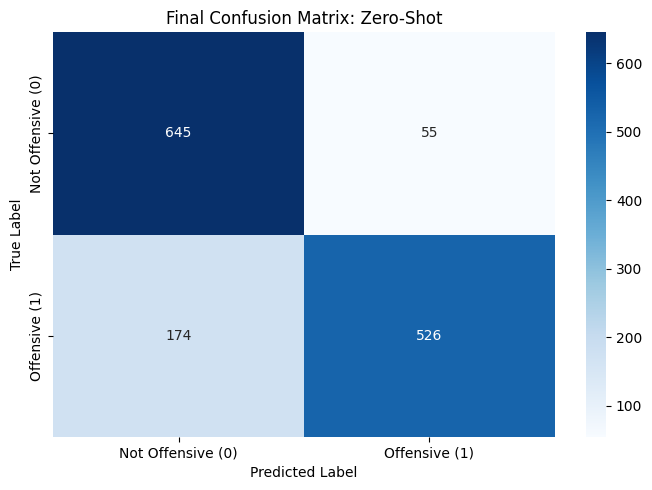


Technique: Few-Shot
                   precision    recall  f1-score   support

Not Offensive (0)       0.95      0.73      0.83       700
    Offensive (1)       0.78      0.96      0.86       700

         accuracy                           0.84      1400
        macro avg       0.86      0.84      0.84      1400
     weighted avg       0.86      0.84      0.84      1400

Accuracy: 0.8450


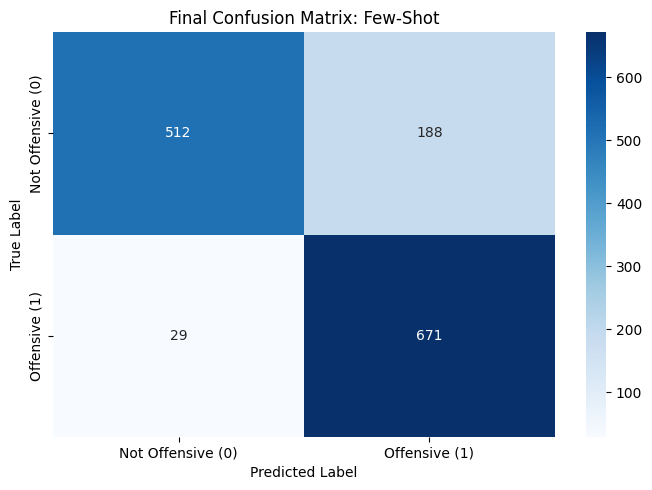


Technique: CoT-Zero-Shot
                   precision    recall  f1-score   support

Not Offensive (0)       0.62      0.70      0.66       700
    Offensive (1)       0.66      0.57      0.61       700

         accuracy                           0.63      1400
        macro avg       0.64      0.63      0.63      1400
     weighted avg       0.64      0.63      0.63      1400

Accuracy: 0.6343


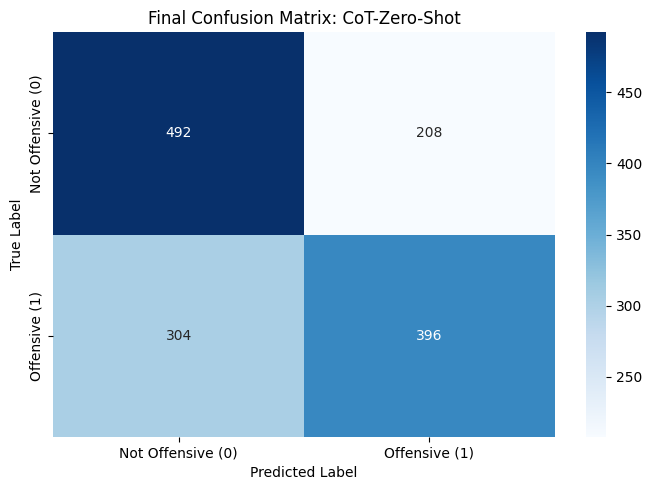


Technique: CoT-Few-Shot
                   precision    recall  f1-score   support

Not Offensive (0)       0.72      0.96      0.83       700
    Offensive (1)       0.95      0.63      0.76       700

         accuracy                           0.80      1400
        macro avg       0.83      0.80      0.79      1400
     weighted avg       0.83      0.80      0.79      1400

Accuracy: 0.7979


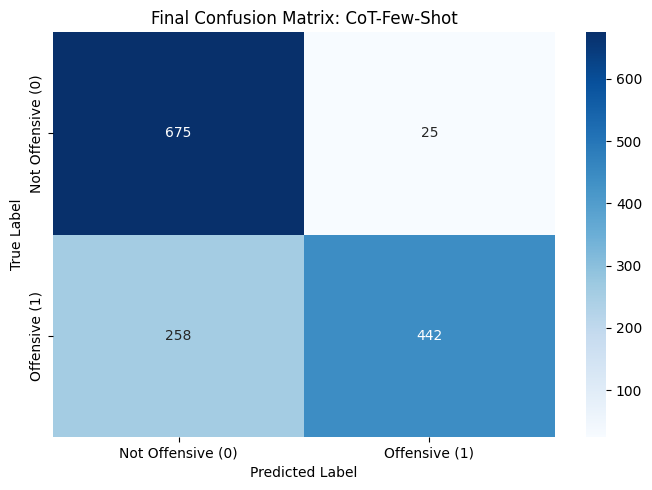

In [11]:
# Execution Loop

LLM = llama
N_SAMPLES = 1400
subset_test = test_df.sample(n=N_SAMPLES, random_state=42)

warnings.filterwarnings("ignore", category=FutureWarning)

results = {
    "Zero-Shot": [],
    "Few-Shot": [],
    "CoT-Zero-Shot": [],
    "CoT-Few-Shot": []
}
true_labels = subset_test['label'].tolist()

for index, row in tqdm(subset_test.iterrows(), total=N_SAMPLES):
    text = row['text']
    
    # 1. Zero Shot
    r_zero = query_llm(create_zero_shot_prompt(text), LLM)
    results["Zero-Shot"].append(parse_response(r_zero))
    
    # 2. Few Shot
    r_few = query_llm(create_few_shot_prompt(text, train_df), LLM)
    results["Few-Shot"].append(parse_response(r_few))

    # 3. CoT Zero Shot
    r_cot_zs = query_llm(create_cot_prompt_zs(text), LLM)
    results["CoT-Zero-Shot"].append(parse_response(r_cot_zs))

    # 4. CoT Few Shot
    r_cot_fs = query_llm(create_cot_prompt_fs(text), LLM)
    results["CoT-Few-Shot"].append(parse_response(r_cot_fs))


# Final Report
print("\n" + "="*30)
print("FINAL RESULTS REPORTs")
print("="*30)

target_names = ['Not Offensive (0)', 'Offensive (1)']

for technique, preds in results.items():
    print(f"\nTechnique: {technique}")
    
    # Handle parsing errors (-1) by treating them as errors (mismatches)
    clean_preds = [p if p != -1 else (1 if true_labels[i] == 0 else 0) for i, p in enumerate(preds)]
    
    print(classification_report(true_labels, clean_preds, target_names=target_names))
    print(f"Accuracy: {accuracy_score(true_labels, clean_preds):.4f}")

    # Confusion Matrix Heatmap for each technique report
    cm = confusion_matrix(true_labels, clean_preds)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names,
                yticklabels=target_names)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Final Confusion Matrix: {technique}")
    plt.tight_layout()
    plt.show()